In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model, Sequential

from tensorflow.keras.layers import Dense, Input

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell
#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")  

2024-06-03 12:11:13.712648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


----
## Project: Forecasting Traffic Volume with DL
-----

We will use the metro interstate traffic volume data- set available on the UCI machine learning repository. The original dataset recorded the hourly westbound traffic on I-94 between Minneapolis and St. Paul in Minnesota, from 2012 to 2018. For the purpose of learning how to apply deep learning for time series forecasting, the dataset has been shortened and cleaned to get rid of missing values. 


### 1. Explore data
--------

In [2]:
df = pd.read_csv('metro_interstate_traffic_volume_preprocessed.csv')

df.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,0,0,2443.0


In [3]:
df.shape

(17551, 6)

In [3]:
df.tail()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
17546,2018-09-30 19:00:00,283.45,0.0,0,75,3543.0
17547,2018-09-30 20:00:00,282.76,0.0,0,90,2781.0
17548,2018-09-30 21:00:00,282.73,0.0,0,90,2159.0
17549,2018-09-30 22:00:00,282.09,0.0,0,90,1450.0
17550,2018-09-30 23:00:00,282.12,0.0,0,90,954.0


17551 hourly data from September 29, 2016 5pm until september 30, 2018 23:00 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17551 entries, 0 to 17550
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date_time       17551 non-null  object 
 1   temp            17551 non-null  float64
 2   rain_1h         17551 non-null  float64
 3   snow_1h         17551 non-null  int64  
 4   clouds_all      17551 non-null  int64  
 5   traffic_volume  17551 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 822.8+ KB


Features:

- `date_time` has a dtype `object`, we may parse it to render it dtype `datetime` 
- `temp`: Average temperature (in Kelvin) reported in the hour 
- `rain_1h`: Amount of rain that occurred in the hour, expressed in millimeters.
- `snow_1h`: Amount of snow that occurred in the hour, expressed in millimeters. 
- `clouds_all`: Percentage of cloud cover during the hour.
- `traffic_volume`: Volume of traffic reported westbound on I-94 during the hour.


In [5]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17551 entries, 0 to 17550
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date_time       17551 non-null  datetime64[ns]
 1   temp            17551 non-null  float64       
 2   rain_1h         17551 non-null  float64       
 3   snow_1h         17551 non-null  int64         
 4   clouds_all      17551 non-null  int64         
 5   traffic_volume  17551 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 822.8 KB


In [7]:
df.set_index('date_time', inplace = True)

In [8]:
df.index.freq = 'H'

In [9]:
df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,
2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
2016-09-29 21:00:00,284.31,0.0,0,0,2443.0


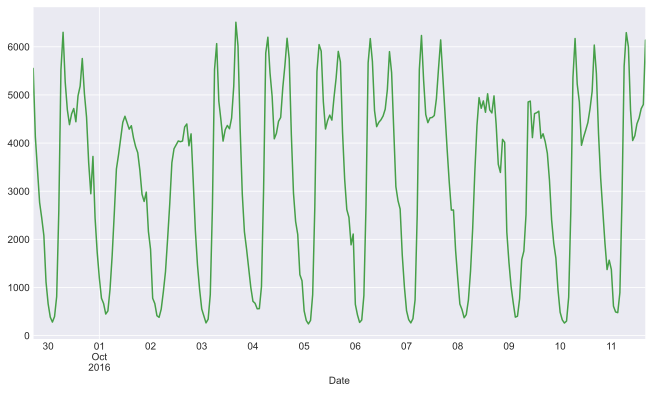

In [10]:
# plot first two weeks 

fig, axes = plt.subplots(figsize = (11,6))

df.iloc[:288]['traffic_volume'].plot(ax = axes, color = 'green', alpha = 0.7)

axes.set_xlabel('Date')

axes.grid()

Daily seasonality is clear: at the beginning and end of each day traffic volume dips while it has peaks in normal work hours. During weekends it also has lower volume as compared to the weekdays (see below for the weekends for this time frame we are plotting). Overall volume over the two weeks does not seem to be increasing but this is not enough to say anything about the trend of the entire dataset. 

In [11]:
dates = pd.DataFrame()

dates['date'] = df.iloc[:288].index.date

weekends = dates[df.iloc[:288].index.weekday >= 5]['date'].unique()

print(weekends)

[datetime.date(2016, 10, 1) datetime.date(2016, 10, 2)
 datetime.date(2016, 10, 8) datetime.date(2016, 10, 9)]


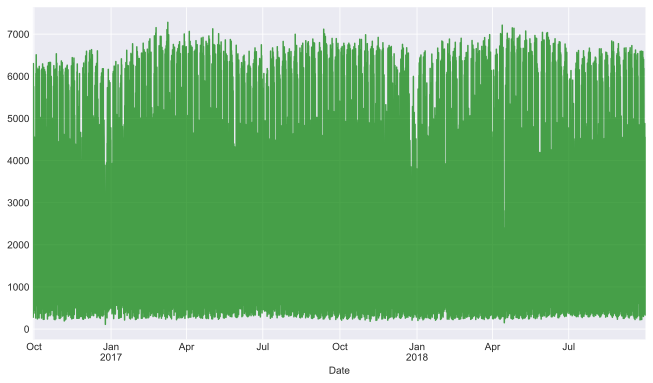

In [12]:
# plot the whole data 

fig, axes = plt.subplots(figsize = (11,6))

df['traffic_volume'].plot(ax = axes, color = 'green', alpha = 0.7)

axes.set_xlabel('Date')

axes.grid()

The entire data does not seem to have an overall trend that increases over the years. This suggests that we can perform a min-max scaling to the data before we feed it into a DL framework. Such a process increases the model efficiency by reducing the training time and improving their performence. Note that if there was a clear trend min-max scaling would be useless as we eventually split the data into training and test set. This is because the model (any model) can not simply learn beyond the scale it is trained

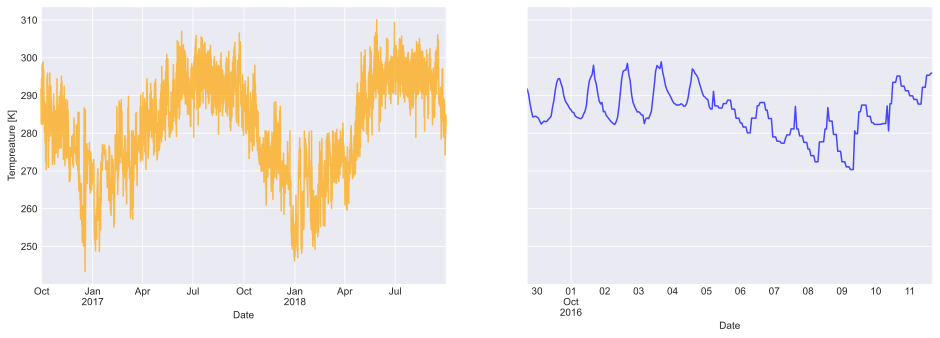

In [13]:
# Lets also plot the temperature for two different resolutions to grasp its seasonality in different granulity 

fig, axes = plt.subplots(1,2, figsize = (16,5), sharey = True)

df['temp'].plot(ax = axes[0], color = 'orange', alpha = 0.7)
df.iloc[:288]['temp'].plot(ax = axes[1], color = 'blue', alpha = 0.7)

for i in range(2):
    
    axes[i].grid()
    axes[i].set_ylabel('Tempreature [K]')
    axes[i].set_xlabel('Date')


From the left figure, yearly seasonality of the temperature is clear whereas from the right the daily seasonality where temperatures are low at the beginning and end of the day.

#### 1.1 Feature engineering and train-test split
------
With our data exploration done, we’ll move on to feature engineering and data splitting. In this section, we will study each feature and create new ones that will help our models forecast the traffic volume and hourly temperature. Finally, we’ll split the data and save each set as a CSV file for later use.

In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,17551.0,281.416203,12.688262,243.39,272.22,282.41,291.89,310.07
rain_1h,17551.0,0.025523,0.259794,0.00,0.00,0.00,0.00,10.60
snow_1h,17551.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
clouds_all,17551.0,42.034129,39.065960,0.00,1.00,40.00,90.00,100.00
traffic_volume,17551.0,3321.484588,1969.223949,113.00,1298.00,3518.00,4943.00,7280.00


Notice that for this dataset, most of the values in the `rain_1h` is 0 which tells us that we can not gain much information about the target from this predictor. In the same way, the entire `snow_1h` column is 0. We will drop these columns from our data frame as they can not be used as predictors for the model.  

In [15]:
df = df.drop(['rain_1h', 'snow_1h'], axis = 1)

df.head()

,temp,clouds_all,traffic_volume
date_time,,,
2016-09-29 17:00:00,291.75,0,5551.0
2016-09-29 18:00:00,290.36,0,4132.0
2016-09-29 19:00:00,287.86,0,3435.0
2016-09-29 20:00:00,285.91,0,2765.0
2016-09-29 21:00:00,284.31,0,2443.0


Next we would like to engineer a feature that can be useful in capturing the cyclical nature of the time-series. Especially the daily seasonality. For this purpose we first express each time step in seconds which will be monotoic in seconds as time has one direction. The turn this something in cyclical nature we will apply sine and cosine transformations. 

In [16]:
from datetime import datetime

timestamp_s = df.index.map(datetime.timestamp)

timestamp_s[1]-timestamp_s[0] == 3600 # each consequtive time stamp has 3600 second difference

True

In [17]:
day_sec = 24 * 60 * 60 #total seconds in a day

df['day_sin'] = (np.sin(timestamp_s * (2*np.pi)/day_sec)).values

df['day_cos'] = (np.cos(timestamp_s * (2*np.pi)/day_sec)).values 

# sin transformation alone is not sufficient because it does not distinguish between pi/2 (say 6 am) and 3pi/2 (say 6pm) 
# we therefore engineer another feature using cos x-form as it is known to be out of phase with sin
# In essence we use sin and cos features as basis vectors for any cyclical pattern that can be present in time  

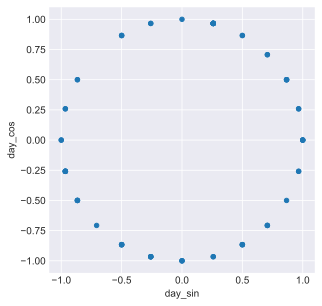

In [18]:

df.sample(72).plot.scatter('day_sin','day_cos').set_aspect('equal');

plt.grid()

Notice that the points form a circle, just like a clock. Therefore, we have successfully expressed each timestamp as a point on the clock, meaning that we now have numerical values that retain the cyclical nature of time in a day, and this can be used in our deep learning models. This will be useful since we observed daily seasonality for both the temperature and the volume of traffic.

In [19]:
# train, validation and test split: 70,20,10 percent 

n = len(df)

train_df, val_df, test_df = df.iloc[:int(n*0.7)].copy(), df.iloc[int(n*0.7):int(n*0.9)].copy(), df.iloc[int(n*0.9):].copy()

n == len(train_df) + len(val_df) + len(test_df)

True

In [21]:
# min-max scaling 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(train_df) # we fit only train set 

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

Notice that we did not normalize the data which also changes (apart from scaling) its distribution by rendering it a Gaussian curve. Since we are using DL models here, this is fine as no assumptions made for the inputs as compared to other models that requires Gaussian distributed inputs. 

In [23]:
# Next we save the data 

train_df.to_csv('train.csv')
val_df.to_csv('val.csv')
test_df.to_csv('test.csv')

### 2. Generating Data Windows (consist of predictors/inputs and target labels) and establishing baseline for DL 
-----

To be able to NNs to process the (training) data we need to generate Data windows of a certain size that consists of a specific number of inputs and labels. The number of inputs and labels may vary depending on the problem we want to tackle and the questions we want to answer. For example we might want to predict the next time step given a certain amount of past values in the time series. By generating such data windows for the entire data set, we essentially generate a certain number of batches each consist of a certain amount of data windows which in turn consist of a certain number of steps in the time-series. 

Each time when a NN processes the entire dataset (by going through all the batches) is called an *epoch* . NN will go through many epochs to optimize the model parameters.

Another important consept related to data windowing is *shuffling*. In the context of time series forecasting, this may seem wrong as the time order of the data matters however shuffling here referes to the process of shuffling different data windows withing a Batch which as we mentioned before consist of many data windows. Therefore shuffling does not refer to shuffling the order of time steps within a data window!

For the purpose of generating data windows that consist of inputs and lables, we will define a generic `DataWindow` class that is based on the width of the input, width of the labels and the shift: For example, given the hourly data if we feed 24 hours of data to make prediction(s), input width is 24. Similarly, the label width refers to the number of timesteps that we want to make predictions. If we want to predict the next time step the width is 1, if we are interested in predictions over the entire next day it is 24. Finally, the number of steps seperating the inputs and predictions gives the shift. If we predict the next time step the shift is 1, if we predict the next 24 hours, it is 24.

In summary, in the case if we use the past 24 hours to predict next 24, we have a data window of size 48 and shift of 24. The width of the inputs and labels is 24. 

In [24]:
class DataWindow():

    def __init__(self, input_width, label_width, shift, train_df = train_df, val_df = val_df, test_df = test_df, label_columns = None):
        
        '''Initialization function that assigns variables and manages indices of inputs and labels'''
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns # Name(s) of the target column(s)
        
        # Assigning dictionaries to label and feature names (as keys) with specified indices as values 
        if label_columns is not None:
        
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)} # a dictionary with the name of label column as key
                                                                                           # and index i as the value

        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} # a dictionary with feature column names as keys # and an index i as values.
                                                                                   # It will be used to split featurus from the target(s)
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.tot_dwindow_size = input_width + shift # total data window size

        # assigning input and label indices within a data window 

        self.input_slice = slice(0, input_width) # slice function determines how to split a sequence                                      
        self.input_indices = np.arange(self.tot_dwindow_size)[self.input_slice]

        self.label_s_idx = self.tot_dwindow_size - self.label_width # label start index 
        self.label_slice = slice(self.label_s_idx, None) # slice from the start till the end 
        self.label_indices = np.arange(self.tot_dwindow_size)[self.label_slice]

    def split_inputs_labels(self, features): # method to split the data window into inputs and label 

        inputs = features[:, self.input_slice, :] 
        labels = features[:, self.label_slice, :]

        if self.label_columns is not None: # if we have more than one label we stack the labels 

            labels = tf.stack([labels[:,:,self.column_indices[name]] for name in self.label_columns], axis = -1)

            inputs.set_shape([None, self.input_width, None]) # the full shape will be [# of batches, time, features]
            labels.set_shape([None, self.label_width, None]) # At this point, we only specify the time dimension and allow the batch and feature dimensions to be defined later.

        return inputs, labels 

    def plot(self, model = None, plot_col = 'traffic_volume', max_subplots = 3):
        
        ''' function to plot the input data, the predictions, and the actual values. Since we will be working with many time windows, 
            we will show only the plot of three time windows, but this parameter can easily be changed.  '''

        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
       
        
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)
            
            if self.label_columns:
                
                label_col_index = self.label_columns_indices.get(plot_col, None)

            else:
                
                label_col_index = plot_col_index

            if label_col_index is None:
                
                continue

            # plot true values, as green squares.        
            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', marker='s', label='Labels', c='green', s=64)

            if model is not None:

                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index], edgecolors='k', marker='X', label='Predictions', c='red', s=64)

            if n == 0:

                plt.legend()

            plt.grid()


        plt.xlabel('Time [h]')
        


    def make_dataset(self, data): # data will be our train, val and test

        data = np.array(data, dtype=np.float32)

        ds = tf.keras.preprocessing.timeseries_dataset_from_array(data = data, targets = None, sequence_length = self.tot_dwindow_size, sequence_stride = 1, shuffle = True, batch_size = 32)

        # targets are set to None because the split_inputs_labels function will take care of it

        ds = ds.map(self.split_inputs_labels)

        return ds

    # defining some properties to apply the make_dataset function on the training, validation, and testing sets.
    # We also create a sample batch that we’ll cache within the class for plotting purposes.    

    @property
    def train(self):
         
        return self.make_dataset(self.train_df)

    @property
    def val(self):
            
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):

        result = getattr(self, '_sample_batch', None)
    
        if result is None:
    
            result = next(iter(self.train))
            self._sample_batch = result
    
        return result                                                                               
         
                                                                                    

#### 2.1 Applying Baseline Models
-----

With the DataWindow class complete, we are ready to use it. We will apply baseline models as single-step, multi-step, and multi-output models.

In [25]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1,label_columns=['traffic_volume'])

wider_window = DataWindow(input_width=24, label_width=24, shift=1,label_columns=['traffic_volume'])

In [26]:
# Class to return inputs as prediction(s)
# Naive forecast assigns the last observed value as the prediction. Basically, the prediction is simply the input data point. 
# This is implemented by the class Baseline.

class Baseline(Model):
    def __init__(self, label_index=None):
        
        super().__init__()
        
        self.label_index = label_index
    
    def call(self, inputs):
        
        if self.label_index is None:
            return inputs   # if target index is not specified return all inputs 
                            # This is useful for multi-output models where all columns are to be predicted.
        
        elif isinstance(self.label_index, list): # If we specify a list of targets, it will return only the specified columns. Again, this is used for multi-output models.
        
            tensors = []
        
            for index in self.label_index:
        
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
        
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

With the class defined, we can now initialize the model and compile it to generate predictions. To do so, we’ll find the index of our target column, `traffic_volume`, and pass it in to Baseline. 

In [27]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

column_indices

{'temp': 0, 'clouds_all': 1, 'traffic_volume': 2, 'day_sin': 3, 'day_cos': 4}

In [28]:
# build the baseline model and compile 

baseline_naive = Baseline(label_index = column_indices['traffic_volume'])

baseline_naive.compile(loss = MeanSquaredError(), metrics = [MeanAbsoluteError()])

# We use the mean squared error (MSE) as a loss function as it penalizes large errors, and it generally yields well-fitted models. 
# For the evaluation metric, we’ll use the mean absolute error (MAE) for its ease of interpretation.

In [29]:
# We’ll now evaluate the performance of our baseline on both the validation and test sets.

val_performance = dict()
performance = dict()


val_performance['Baseline-Naive'] = baseline_naive.evaluate(single_step_window.val, verbose = 0)
performance['Baseline-Naive'] = baseline_naive.evaluate(single_step_window.test, verbose = 0)

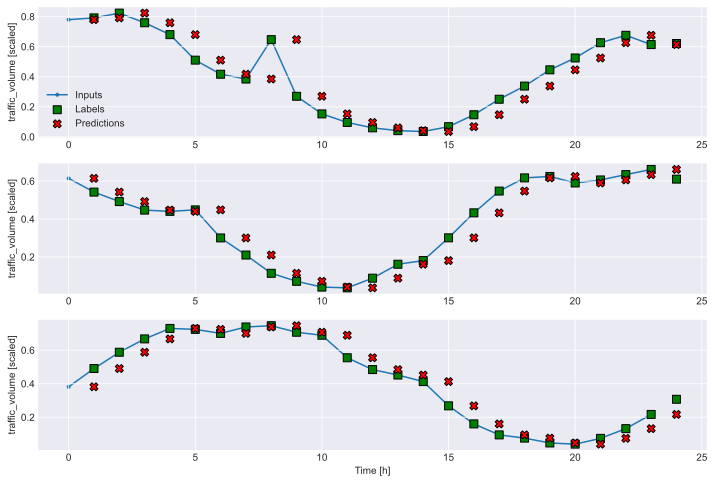

In [30]:
# We can visualize the predictions using the plot method of the DataWindow class. Remember to use the wide_window to see more than just two data points.

wider_window.plot(baseline_naive)

The crosses at each timestep are simply lagged values in the series, i.e last known value, meaning that we have a baseline (naive forecast) that functions as expected.

In [31]:
mae_test_naive = performance['Baseline-Naive'][1]

print(f"Test MAE of the Naive forecast is {mae_test_naive:.3f}")

Test MAE of the Naive forecast is 0.081


More complex NN models should be able to improve this baseline performance!

#### Multi-step baseline models

For multi-step models, we’ll predict more than one timestep into the future. Again, the first step is to generate the appropriate window of data. If we wish to predict next 24 hours given the past 24: the input width is 24, the label width is 24 and so does the shift. 



In [32]:
multi_window = DataWindow(input_width = 24, label_width = 24, shift = 24, label_columns = ['traffic_volume'])

With the data window generated, we can now focus on implementing the baseline models. In this situation, there are two reasonable baselines:

- Predict the last known value for the next 24 timesteps.
- Predict the last 24 timesteps for the next 24 timesteps.

With that in mind, let’s implement the first baseline, where we’ll simply repeat the last
known value over the next 24 timesteps.

In [33]:
class MultiStepBaseline(Model):
    
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        
        if self.label_index is None:
                 
            return tf.tile(inputs[:,-1:,:], [1,24,1]) # If no target is specified, return the last known value of all columns over the next 24 timesteps.

        return tf.tile(inputs[:,-1:,self.label_index:], [1,24,1]) # else return the last known value of the target column over the next 24 timesteps.

        

In [34]:
# initiate, compile and evaluate the performence of the model on the val and test sets 

ms_val_performance = dict()
ms_test_performance = dict()

ms_baseline_naive = MultiStepBaseline(label_index = column_indices['traffic_volume'])

ms_baseline_naive.compile(loss = MeanSquaredError(), metrics = [MeanAbsoluteError()])

ms_val_performance['MS-Baseline-Naive'] = ms_baseline_naive.evaluate(multi_window.val, verbose = 0)
ms_test_performance['MS-Baseline-Naive'] = ms_baseline_naive.evaluate(multi_window.test, verbose = 0)

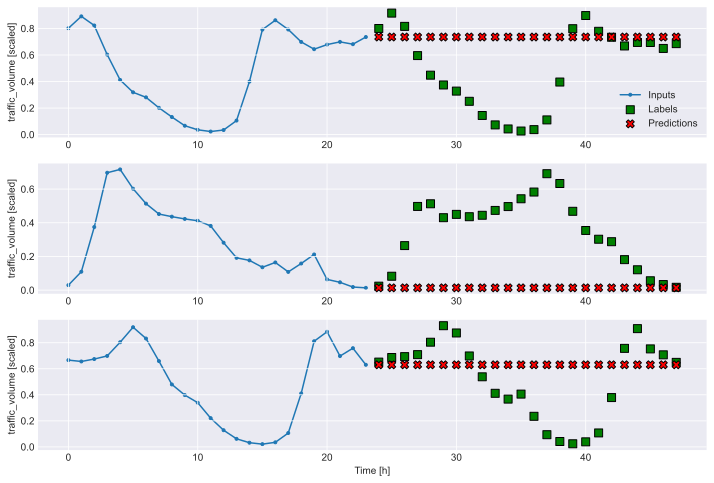

In [35]:
multi_window.plot(ms_baseline_naive)

In [36]:
ms_mae_test_naive = ms_test_performance['MS-Baseline-Naive'][1]

print(f"Test MAE for multi-step Naive model is {ms_mae_test_naive:.3f}")

Test MAE for multi-step Naive model is 0.347


Now let’s see if we can build a better baseline by simply repeating the input sequences. Let’s implement a second baseline for multi-step models, which simply returns the input sequence. This means that the prediction for the next 24 hours will simply be the last known 24 hours of data.

In [37]:
class MultiStepRepeatBaseline(Model):
    
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        
        if self.label_index is None:
                 
            return inputs[:,:,:] # If no target is specified, return the last n inputs as predictions for the next n timesteps.

        return inputs[:,:,self.label_index:] # else return the same for the specified target index

In [38]:
ms_baseline_rep = MultiStepRepeatBaseline(label_index = column_indices['traffic_volume'])

ms_baseline_rep.compile(loss = MeanSquaredError(), metrics = [MeanAbsoluteError()])

ms_val_performance['MS-Baseline-Rep'] = ms_baseline_rep.evaluate(multi_window.val, verbose = 0)
ms_test_performance['MS-Baseline-Rep'] = ms_baseline_rep.evaluate(multi_window.test, verbose = 0)

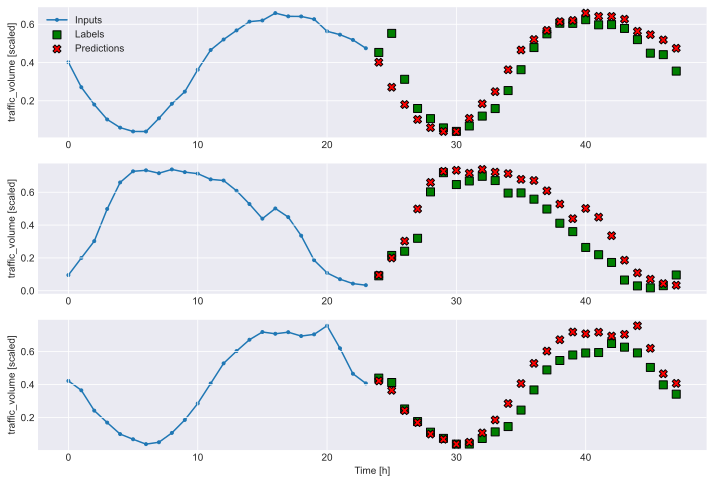

In [187]:
multi_window.plot(ms_baseline_rep)

In [39]:
ms_mae_test_rep = ms_test_performance['MS-Baseline-Rep'][1]

print(f"Test MAE for multi-step naive repeat model is {ms_mae_test_rep:.3f}")

Test MAE for multi-step naive repeat model is 0.315


The results indicate that we indeed established a better baseline by using repeatative naive forecast model where last n values gives the predictions. 

#### Multi-output baseline model
------
The final type of model we’ll cover is the multi-output model. In this situation, we wish to predict more than one target. For the problem at hand, we will predict the traffic volume and the temperature for the next timestep using a single input data point. Essentially, we’re applying the single-step model on both the traffic volume and temperature, making it a multi-output model.

Again, we’ll start off by defining the window of data, but here we’ll define two windows: one for training and the other for visualization. Since the model takes in one data point and outputs one prediction, we want to initialize a wide window of data to visualize many predictions over many timesteps.

In [40]:
mo_single_step_window = DataWindow(input_width = 1, label_width = 1, shift = 1, label_columns = ['temp', 'traffic_volume'])

mo_wide_window = DataWindow(input_width = 24, label_width = 24, shift = 1, label_columns = ['temp', 'traffic_volume'] )

In [41]:
# We can utilize the Baseline Class we defined earlier for a multi-output problems 

mo_val_performance = dict()
mo_test_performance = dict()

mo_baseline_naive = Baseline(label_index = [column_indices['temp'], column_indices['traffic_volume']])

mo_baseline_naive.compile(loss = MeanSquaredError(), metrics = [MeanAbsoluteError()])

mo_val_performance['MO-Baseline-Naive'] = mo_baseline_naive.evaluate(mo_single_step_window.val, verbose = 0)
mo_test_performance['MO-Baseline-Naive'] = mo_baseline_naive.evaluate(mo_single_step_window.test, verbose = 0)

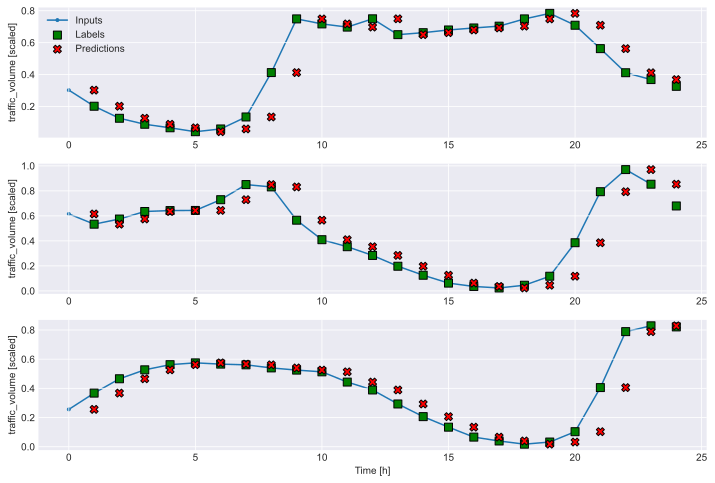

In [42]:
mo_wide_window.plot(mo_baseline_naive) # recall that plot method by default returns traffic_volume column, for temperature we need to specify it 

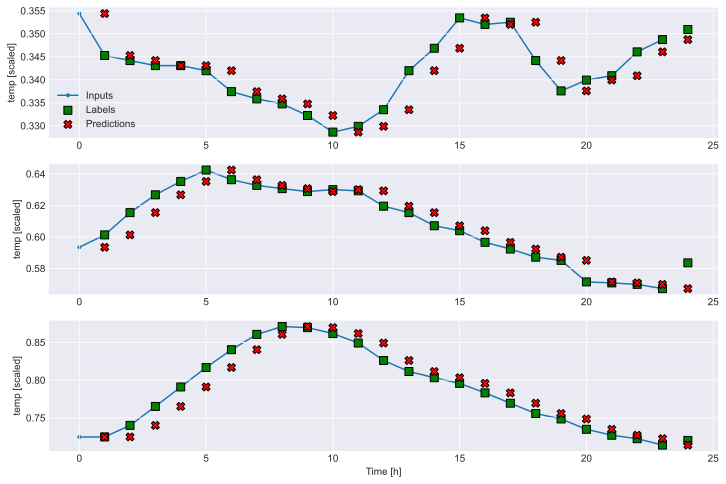

In [43]:
mo_wide_window.plot(mo_baseline_naive, plot_col = 'temp')

In [45]:
mo_mae_test_naive = mo_test_performance['MO-Baseline-Naive'][1]

print(f"Test MAE for multi-output naive repeat model is {mo_mae_test_naive:.3f}")

Test MAE for multi-output naive repeat model is 0.047


### 3. Deep Learning:
-------

We will start with the simplest deep learning model, which is not deep in the end, having only one output layer without any hidden layers. We are going to refer it as *linear model*. In contrast, a *deep neural network* has at least one hidden layer, allowing us to start modeling nonlinear relationships between the features and the target, usually resulting in better forecasts.


#### 3.1 Linear Model
-----

A linear model is the simplest architecture we can implement in deep learning. In fact, we might argue that it is not deep learning at all, since the model has no hidden layer. Each input feature is simply given a weight, and they are combined to output a prediction for the target, just like in a traditional linear regression.

Lets first consider a single step model where we utilize features at time `t` to forecast the `traffic_volume` at time `t+1`. For this purpose, we can use `cloud_all`, `temp`, `day_sin`, `day_cos`, as well the `traffic_volume` at time `t` to predict the latter at time `t+1`: 

$$ \textrm{traffic vol}_{t+1} = \beta_0 + \sum_{i = 1}^{5} w_i\, x_{i,t} $$



In [46]:
# for training
single_step_window = DataWindow(input_width=1, label_width=1, shift=1,label_columns=['traffic_volume'])

# for plotting
wider_window = DataWindow(input_width=24, label_width=24, shift=1,label_columns=['traffic_volume'])

Unlike a baseline model, a linear model actually requires training. Thus, we’ll define a `compile_and_fit` function that configures the model for training and then fits the model on the data.

In [47]:
def compile_and_fit(model, window, patience = 3, max_epochs = 50): # takes a model and a window of data from the DataWindow class 
                                                                   # The patience is the number of epochs after which the model should stop training if the validation loss
                                                                   # does not improve; max_epochs sets a maximum number of epochs to train the model.
        early_stopping = EarlyStopping(monitor = 'val_loss', patience = patience, mode = 'min')

        model.compile(loss = MeanSquaredError(), optimizer = 'adam', metrics = [MeanAbsoluteError()])

        history = model.fit(window.train, epochs = max_epochs, validation_data = window.val, callbacks = [early_stopping])

        return history

In [48]:
# Simple Linear ANN

linear_ann = Sequential([Dense(1)])

In [49]:
# compile and fit 

history = compile_and_fit(linear_ann, single_step_window)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4064 - mean_absolute_error: 0.5192 - val_loss: 0.2011 - val_mean_absolute_error: 0.3660
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1800 - mean_absolute_error: 0.3444 - val_loss: 0.1276 - val_mean_absolute_error: 0.2919
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1109 - mean_absolute_error: 0.2715 - val_loss: 0.0856 - val_mean_absolute_error: 0.2406
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0733 - mean_absolute_error: 0.2213 - val_loss: 0.0611 - val_mean_absolute_error: 0.2033
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0520 - mean_absolute_error: 0.1856 - val_loss: 0.0452 - val_mean_absolute_error: 0.1736
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0381 - mean_absolute_error: 0.1574 - val_loss: 0.0335 - val_mean_absolute_error: 0.1477
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0285 - mean_absolute_error: 0.1343 - v

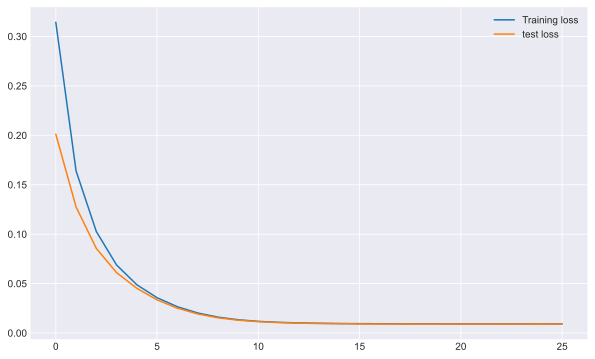

In [53]:
fig, axes = plt.subplots(figsize = (10,6))

axes.plot(history.history['loss'], label = 'Training loss')
axes.plot(history.history['val_loss'], label = 'test loss')

axes.grid()
axes.legend()

In [54]:
# Evaluate model performence in the validation and  test set by appending to the val_performance and performence dictionaries we defined earlier 

val_performance['linear_ann'] = linear_ann.evaluate(single_step_window.val, verbose = 0)
performance['linear_ann'] = linear_ann.evaluate(single_step_window.test, verbose = 0)

In [55]:
val_performance # performance on the validation set is better than naive one step forecast 

{'Baseline-Naive': [0.013317284174263477, 0.08305121958255768],
 'linear_ann': [0.009044165723025799, 0.06555026769638062]}

In [56]:
performance # same for the test set as expected 

{'Baseline-Naive': [0.012481081299483776, 0.08128399401903152],
 'linear_ann': [0.008390962146222591, 0.06188899278640747]}

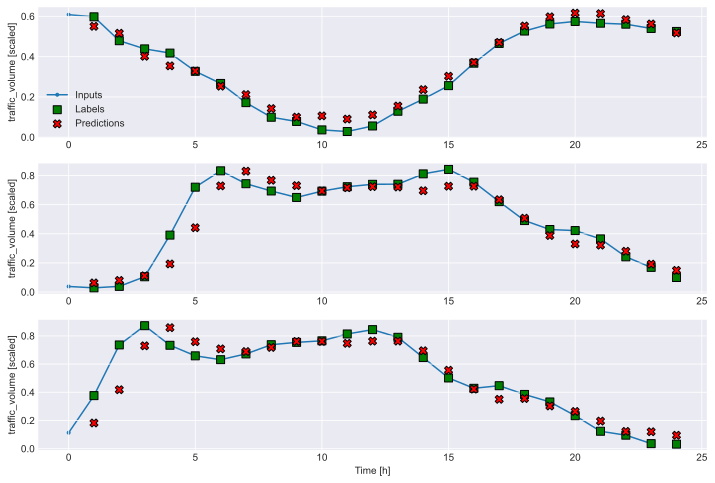

In [57]:
# plot of predictions vs true values taken from random batches of data 

wider_window.plot(linear_ann)

The simple linear model makes fairly good predictions, as we can observe some overlap between the forecasts and the actual values.

#### 3.2 Multi-step linear model
------

Now we want to predict the next 24 hours of data using an input window of 24 hours of data.

In [58]:
ms_linear = Sequential([Dense(1, kernel_initializer= tf.initializers.zeros)]) # we initialize the weigths at zero to speed up the training process

In [59]:
history = compile_and_fit(ms_linear, multi_window)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1408 - mean_absolute_error: 0.3085 - val_loss: 0.0404 - val_mean_absolute_error: 0.1667
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0328 - mean_absolute_error: 0.1475 - val_loss: 0.0238 - val_mean_absolute_error: 0.1194
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0208 - mean_absolute_error: 0.1105 - val_loss: 0.0206 - val_mean_absolute_error: 0.1066
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0182 - mean_absolute_error: 0.0997 - val_loss: 0.0196 - val_mean_absolute_error: 0.1011
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0172 - mean_absolute_error: 0.0943 - val_loss: 0.0189 - val_mean_absolute_error: 0.0969
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0166 - mean_absolute_error: 0.0906 - val_loss: 0.0185 - val_mean_absolute_error: 0.0936
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0163 - mean_absolute_error: 0.0881 - v

In [60]:
ms_val_performance['ms_linear_ann'] = ms_linear.evaluate(multi_window.val, verbose= 0)
ms_test_performance['ms_linear_ann'] = ms_linear.evaluate(multi_window.test, verbose= 0)

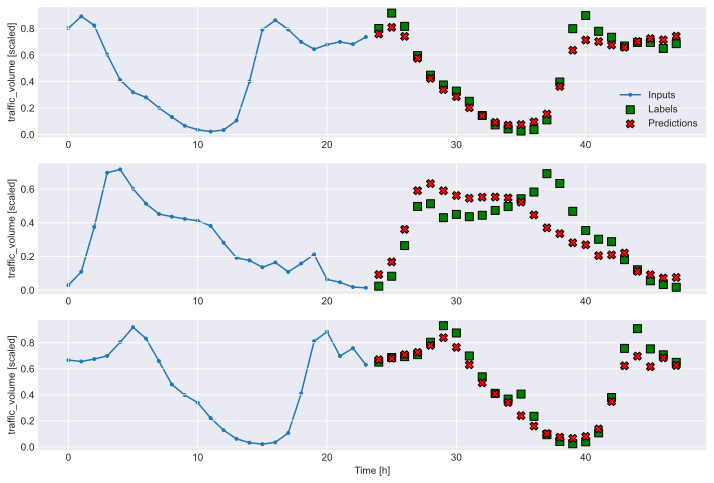

In [61]:
multi_window.plot(ms_linear)

#### 3.3 Multi-output linear model
------

Next we will predict `traffic_volume` and `temp` with a single step method.

In [62]:
mo_linear = Sequential([Dense(2)]) 

history = compile_and_fit(mo_linear, mo_single_step_window)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3516 - mean_absolute_error: 0.4639 - val_loss: 0.1026 - val_mean_absolute_error: 0.2701
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0789 - mean_absolute_error: 0.2394 - val_loss: 0.0436 - val_mean_absolute_error: 0.1712
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0349 - mean_absolute_error: 0.1515 - val_loss: 0.0199 - val_mean_absolute_error: 0.1077
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - mean_absolute_error: 0.0947 - val_loss: 0.0105 - val_mean_absolute_error: 0.0696
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0632 - val_loss: 0.0071 - val_mean_absolute_error: 0.0499
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067 - mean_absolute_error: 0.0492 - val_loss: 0.0059 - val_mean_absolute_error: 0.0420
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059 - mean_absolute_error: 0.0438 - v

In [63]:
# evalute model performence 

mo_val_performance['mo_linear'] = mo_linear.evaluate(mo_single_step_window.val, verbose = 0)
mo_test_performance['mo_linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose = 0)

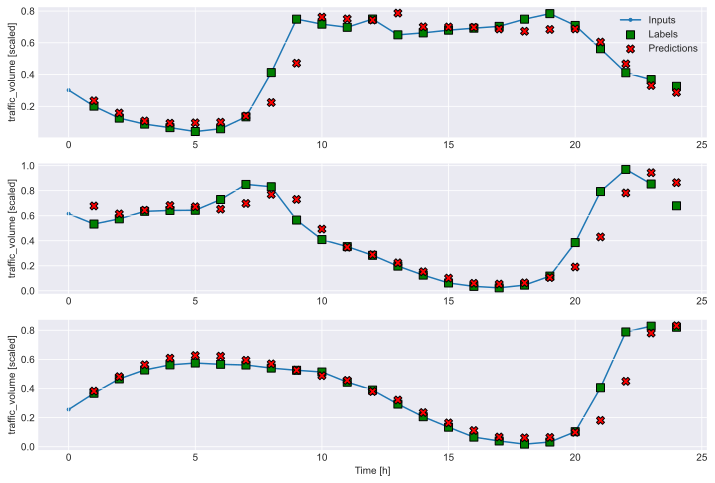

In [64]:
mo_wide_window.plot(mo_linear)

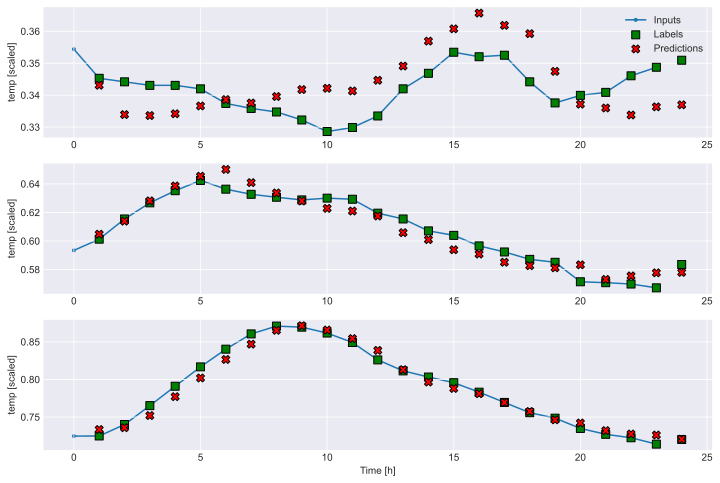

In [65]:
mo_wide_window.plot(mo_linear, plot_col = 'temp')

#### 3.4 Deep Neural Network Model
------

Linear models have no hidden layers; the model had an input layer and an output layer. In a deep neural network (DNN), we’ll add more layers between the input and output layers, called hidden layers. It has been empirically shown that adding hidden layers in neural net- works helps achieve better results. Furthermore, we’ll introduce a nonlinear activation function to capture nonlinear relationships in the data.

In [66]:
# Single step DNN 

ss_dnn = Sequential([Dense(units = 64, activation = 'relu'), Dense(units = 64, activation = 'relu'), Dense(1)])

history = compile_and_fit(ss_dnn, single_step_window)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0310 - mean_absolute_error: 0.1184 - val_loss: 0.0050 - val_mean_absolute_error: 0.0524
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - mean_absolute_error: 0.0526 - val_loss: 0.0033 - val_mean_absolute_error: 0.0445
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036 - mean_absolute_error: 0.0445 - val_loss: 0.0031 - val_mean_absolute_error: 0.0416
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - mean_absolute_error: 0.0414 - val_loss: 0.0037 - val_mean_absolute_error: 0.0484
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0030 - mean_absolute_error: 0.0398 - val_loss: 0.0027 - val_mean_absolute_error: 0.0391
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028 - mean_absolute_error: 0.0388 - val_loss: 0.0027 - val_mean_absolute_error: 0.0397
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029 - mean_absolute_error: 0.0394 - v

In [67]:
# save val and test performance to the dictionary 

val_performance['ss_dnn'] = ss_dnn.evaluate(single_step_window.val, verbose = 0)
performance['ss_dnn'] = ss_dnn.evaluate(single_step_window.test, verbose = 0)

val_performance

{'Baseline-Naive': [0.013317284174263477, 0.08305121958255768],
 'linear_ann': [0.009044165723025799, 0.06555026769638062],
 'ss_dnn': [0.0022089320700615644, 0.03473678231239319]}

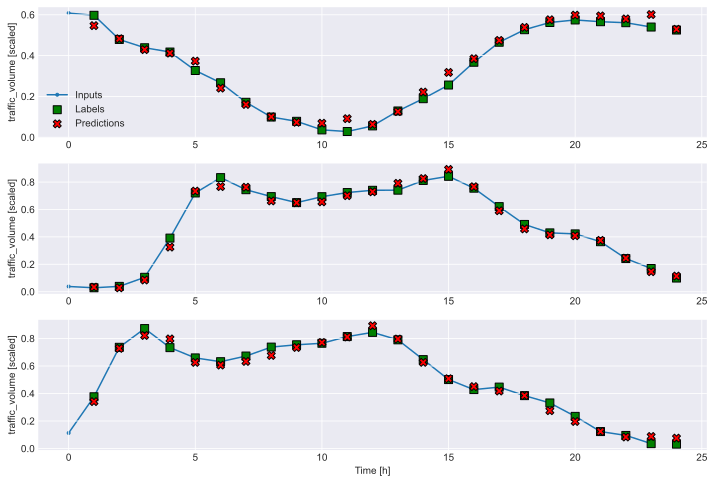

In [69]:
wider_window.plot(ss_dnn)

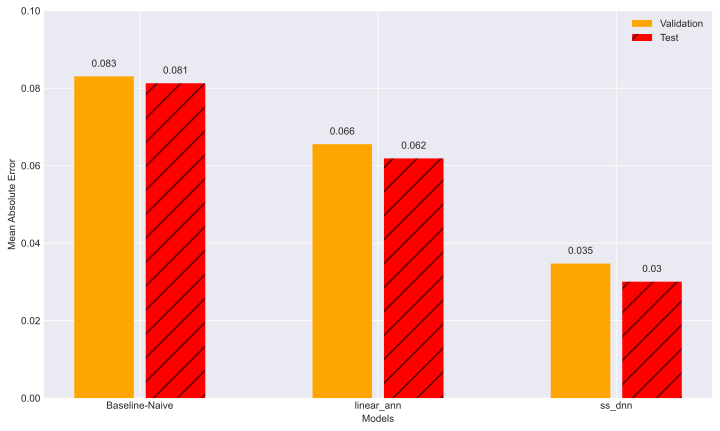

In [70]:
mae_val = [val[1] for val in val_performance.values()]
mae_test = [val[1] for val in performance.values()]

x = np.arange(len(performance))

fig, axes = plt.subplots(figsize = (12,7))

axes.bar(x - 0.15, mae_val, width = 0.25, color = 'orange', label = 'Validation')
axes.bar(x + 0.15, mae_test, width = 0.25, color = 'red', hatch = '/', label = 'Test')

for idx, val in enumerate(mae_val):

    axes.text(s = str(round(val,3)), x = idx - 0.15, y = val + 0.0025, ha = 'center')

for idx, val in enumerate(mae_test):

    axes.text(s = str(round(val,3)), x = idx + 0.15, y = val + 0.0025, ha = 'center')

axes.grid()
axes.set_ylabel('Mean Absolute Error')
axes.set_xlabel('Models')
axes.set_xticks(ticks = x, labels = performance.keys())
axes.set_ylim(0,0.1)
axes.legend()




Both the simple linear model and the DNN outperformed the naive forecast!

In [80]:
# multi-step forecasting with DNN 

ms_dnn = Sequential([Dense(units = 64, activation = 'relu'), Dense(units = 64, activation = 'relu'), Dense(1, kernel_initializer = tf.initializers.zeros)])

history = compile_and_fit(ms_dnn, multi_window)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0644 - mean_absolute_error: 0.1728 - val_loss: 0.0166 - val_mean_absolute_error: 0.0868
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0143 - mean_absolute_error: 0.0790 - val_loss: 0.0155 - val_mean_absolute_error: 0.0834
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0777 - val_loss: 0.0152 - val_mean_absolute_error: 0.0787
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0133 - mean_absolute_error: 0.0771 - val_loss: 0.0150 - val_mean_absolute_error: 0.0809
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - mean_absolute_error: 0.0758 - val_loss: 0.0145 - val_mean_absolute_error: 0.0818
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - mean_absolute_error: 0.0759 - val_loss: 0.0145 - val_mean_absolute_error: 0.0789
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - mean_absolute_error: 0.0754 - v

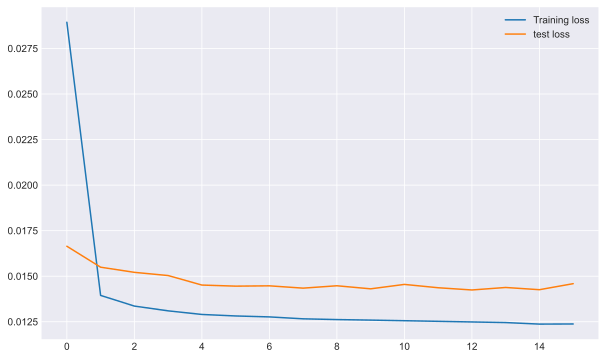

In [81]:
fig, axes = plt.subplots(figsize = (10,6))

axes.plot(history.history['loss'], label = 'Training loss')
axes.plot(history.history['val_loss'], label = 'test loss')

axes.grid()
axes.legend()

In [82]:
# save val and test performance to the dictionary 

ms_val_performance['ms_dnn'] = ms_dnn.evaluate(multi_window.val, verbose = 0)
ms_test_performance['ms_dnn'] = ms_dnn.evaluate(multi_window.test, verbose = 0)

ms_val_performance

{'MS-Baseline-Naive': [0.18734797835350037, 0.3520132303237915],
 'MS-Baseline-Rep': [0.18962839245796204, 0.3275609016418457],
 'ms_linear_ann': [0.018197279423475266, 0.08859215676784515],
 'ms_dnn': [0.014589914120733738, 0.07678606361150742]}

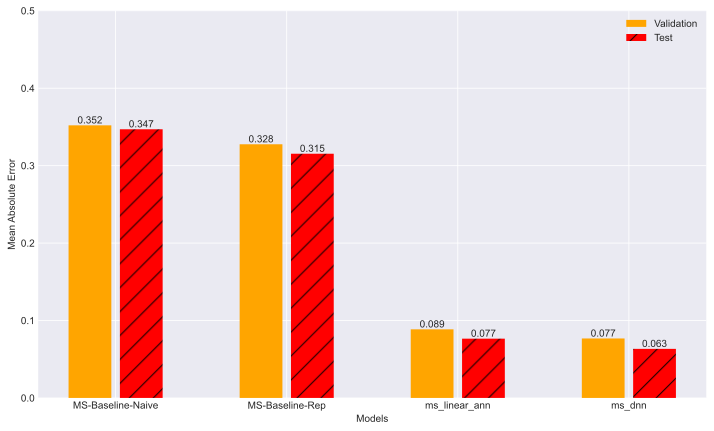

In [83]:
# visualize validation and test errors with respect to other models 

ms_mae_val = [val[1] for val in ms_val_performance.values()]
ms_mae_test = [val[1] for val in ms_test_performance.values()]

x = np.arange(len(ms_test_performance))

fig, axes = plt.subplots(figsize = (12,7))

axes.bar(x - 0.15, ms_mae_val, width = 0.25, color = 'orange', label = 'Validation')
axes.bar(x + 0.15, ms_mae_test, width = 0.25, color = 'red', hatch = '/', label = 'Test')

for idx, val in enumerate(ms_mae_val):

    axes.text(s = str(round(val,3)), x = idx - 0.15, y = val + 0.0025, ha = 'center')

for idx, val in enumerate(ms_mae_test):

    axes.text(s = str(round(val,3)), x = idx + 0.15, y = val + 0.0025, ha = 'center')

axes.grid()
axes.set_ylabel('Mean Absolute Error')
axes.set_xlabel('Models')
axes.set_xticks(ticks = x, labels = ms_test_performance.keys())
axes.set_ylim(0,0.5)
axes.legend()

Multi-step DNN out-performs its linear counterpart! 

In [87]:
# Forecasting multiple time-series with multi output DNN

mo_dnn = Sequential([Dense(units = 64, activation = 'relu'), Dense(units = 64, activation = 'relu'), Dense(2)])

history = compile_and_fit(mo_dnn, mo_single_step_window)


Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0453 - mean_absolute_error: 0.1254 - val_loss: 0.0032 - val_mean_absolute_error: 0.0357
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033 - mean_absolute_error: 0.0348 - val_loss: 0.0024 - val_mean_absolute_error: 0.0323
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.0321 - val_loss: 0.0021 - val_mean_absolute_error: 0.0292
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0024 - mean_absolute_error: 0.0303 - val_loss: 0.0017 - val_mean_absolute_error: 0.0262
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0285 - val_loss: 0.0016 - val_mean_absolute_error: 0.0267
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020 - mean_absolute_error: 0.0274 - val_loss: 0.0015 - val_mean_absolute_error: 0.0258
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - mean_absolute_error: 0.0271 - v

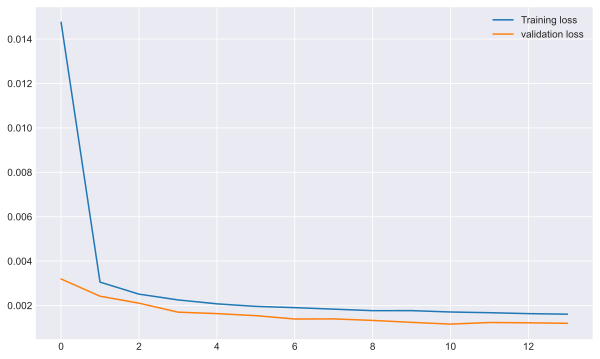

In [88]:
fig, axes = plt.subplots(figsize = (10,6))

axes.plot(history.history['loss'], label = 'Training loss')
axes.plot(history.history['val_loss'], label = 'validation loss')

axes.grid()
axes.legend()

In [95]:
# save val and test performance to the dictionary 

mo_val_performance['mo_dnn'] = mo_dnn.evaluate(mo_single_step_window.val, verbose = 0)
mo_test_performance['mo_dnn'] = mo_dnn.evaluate(mo_single_step_window.test, verbose = 0)

mo_val_performance

{'MO-Baseline-Naive': [0.006859190762042999, 0.0482177808880806],
 'mo_linear': [0.004657458979636431, 0.038656722754240036],
 'mo_dnn': [0.0011985489400103688, 0.022444481030106544]}

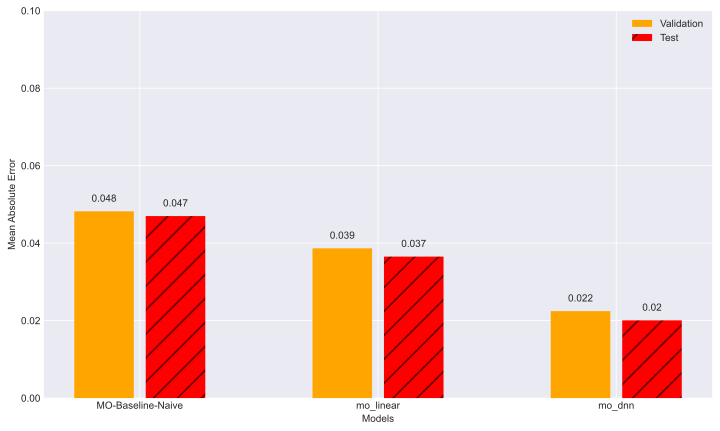

In [98]:
# visualize validation and test errors with respect to other models 

mo_mae_val = [val[1] for val in mo_val_performance.values()]
mo_mae_test = [val[1] for val in mo_test_performance.values()]

x = np.arange(len(mo_test_performance))

fig, axes = plt.subplots(figsize = (12,7))

axes.bar(x - 0.15, mo_mae_val, width = 0.25, color = 'orange', label = 'Validation')
axes.bar(x + 0.15, mo_mae_test, width = 0.25, color = 'red', hatch = '/', label = 'Test')

for idx, val in enumerate(mo_mae_val):

    axes.text(s = str(round(val,3)), x = idx - 0.15, y = val + 0.0025, ha = 'center')

for idx, val in enumerate(mo_mae_test):

    axes.text(s = str(round(val,3)), x = idx + 0.15, y = val + 0.0025, ha = 'center')

axes.grid()
axes.set_ylabel('Mean Absolute Error')
axes.set_xlabel('Models')
axes.set_xticks(ticks = x, labels = mo_test_performance.keys())
axes.set_ylim(0,0.1)
axes.legend()